## U-net First Implementation

The architecture used is the so-called U-Net, which is very common for image segmentation problems such as this. It works well even with small datasets (which is weird for a NN!).

### I. Initial Setup 

#### a) Libraries

In [26]:
# Data download and unzipping
!wget https://raw.githubusercontent.com/epicfaace/laughing-memory/master/Data/stage1_test.zip -cq
!wget https://raw.githubusercontent.com/epicfaace/laughing-memory/master/Data/stage1_train.zip -cq

!mkdir stage1_train stage1_test

!unzip -q -o stage1_train.zip -d stage1_train/
!unzip -q -o stage1_test.zip -d stage1_test/ 


^C
mkdir: cannot create directory ‘stage1_train’: File exists
mkdir: cannot create directory ‘stage1_test’: File exists


In [0]:
!cd 

In [58]:
!ls -l

total 90404
drwxr-xr-x   1 root root     4096 Mar  4 18:15 datalab
drwxr-xr-x  67 root root    12288 Mar  4 18:21 stage1_test
-rw-r--r--   1 root root  9545388 Mar  4 18:21 stage1_test.zip
drwxr-xr-x 672 root root    73728 Mar  4 18:21 stage1_train
-rw-r--r--   1 root root 82923446 Mar  4 18:21 stage1_train.zip
drwxr-xr-x   2 root root     4096 Mar  4 20:01 test


In [0]:
!rm -rf Unet-MeanIoU-80e-Res256-BN-Reg0.05.h5

In [30]:
!cat /proc/meminfo

MemTotal:       13341960 kB
MemFree:         3248472 kB
MemAvailable:   11023408 kB
Buffers:          654172 kB
Cached:          6669956 kB
SwapCached:            0 kB
Active:          4608580 kB
Inactive:        4285508 kB
Active(anon):    1730280 kB
Inactive(anon):   124412 kB
Active(file):    2878300 kB
Inactive(file):  4161096 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:             98444 kB
Writeback:             0 kB
AnonPages:       1570028 kB
Mapped:           414196 kB
Shmem:            284744 kB
Slab:            1028328 kB
SReclaimable:     988956 kB
SUnreclaim:        39372 kB
KernelStack:        3424 kB
PageTables:         8236 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6670980 kB
Committed_AS:    3020316 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
HugePages_Total: 

In [31]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          13029        1739        3171         278        8118       10764
Swap:             0           0           0


In [0]:
!pip install -q tqdm keras

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
import itertools #chain function 

import skimage.io
import skimage.transform
import skimage.morphology
#.io : imread, imshow, imread_collection, concatenate_images
#.transform: resize
#.morphology: label

import keras.models
import keras.layers
import keras.layers.core
import keras.layers.convolutional
import keras.layers.pooling
import keras.layers.merge
import keras.callbacks
#.models: Model, load_model
#.layers: Input
#   .core: Dropout, Lambda 
#   .convolutional: Conv2D, Conv2DTranspose
#   .pooling: MaxPooling2D
#   .merge: concatenate
#.callbacks: EarlyStopping, ModelCheckpoint

from keras import backend as K
import tensorflow as tf

Keras has three backend implementations available: the TensorFlow backend, the Theano backend, and the CNTK backend. It relies on a specialized, well-optimized tensor manipulation library, serving as its "backend engine". 

In [0]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

#### b) Warnings filter

The warnings filter controls whether warnings are ignored, displayed, or turned into errors (raising an exception).
The warnings filter maintains an ordered list of filter specifications. Each entry is a tuple of the form ```(action, message, category, module, lineno).```

For more documentation: [Warning Control](https://docs.python.org/2/library/warnings.html#warning-filter)


In [0]:
#Parameters: Action, 
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [0]:
seed = 42
random.seed = seed
np.random.seed = seed

#### c) Id Retrieval from file explorer

```os.walk()``` walks your directory tree and returns the path, a list of directories, and a list of file (see [doc](https://www.saltycrane.com/blog/2007/03/python-oswalk-example/)). It is an iterator.

In [36]:
#os.walk example
i = 0
for (path, dirs, files) in os.walk(TRAIN_PATH):
    print(path,dirs,files)
    i+=1
    if i == 4:
        break

stage1_train/ ['7ac468eb217b7058d22c1711285d21949b4121bf3fa3217e3e51453666ebecff', '4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381', '10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28', '8e8a7a14749d0b2e48de3d10e2e80063f17b165ad921c8afc0623f08500f3259', 'c169a7782a69ea2f38f64d2739de189e88adbcfd4a829721def8c89ecabe8b71', '4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94', '4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149', 'b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db', 'dbe5ad05b6f87018159a3228c1d1725892a1bfb9fa9f8fcc2e8bfe70d69d0355', '1db1cddf28e305c9478519cfac144eee2242183fe59061f1f15487e925e8f5b5', 'eb96fc6cbf6880bf05c4309857ae33844a4bc2152e228eff31024e5265cf9fc3', 'ea00f5a91ca75e745d675201cc62d7db266f8e2787033e15a7dd5f1cc5c0ad72', 'd8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f53660a', '615985773f1469fbc00915b3e82d1d4942051c09ddea2667e37ad361ed2e9d59', 'dabfee30b46d23569c63fa7253ef10b2

In [0]:
# Get train and test IDs (Next() returns the next item from the iterator)
train_ids = next(os.walk(TRAIN_PATH))[1] #We are interested in list at index 1: List with directories ('str' format) at path 
test_ids = next(os.walk(TEST_PATH))[1]

In [38]:
train_ids, test_ids

(['7ac468eb217b7058d22c1711285d21949b4121bf3fa3217e3e51453666ebecff',
  '4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381',
  '10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28',
  '8e8a7a14749d0b2e48de3d10e2e80063f17b165ad921c8afc0623f08500f3259',
  'c169a7782a69ea2f38f64d2739de189e88adbcfd4a829721def8c89ecabe8b71',
  '4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94',
  '4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149',
  'b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db',
  'dbe5ad05b6f87018159a3228c1d1725892a1bfb9fa9f8fcc2e8bfe70d69d0355',
  '1db1cddf28e305c9478519cfac144eee2242183fe59061f1f15487e925e8f5b5',
  'eb96fc6cbf6880bf05c4309857ae33844a4bc2152e228eff31024e5265cf9fc3',
  'ea00f5a91ca75e745d675201cc62d7db266f8e2787033e15a7dd5f1cc5c0ad72',
  'd8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f53660a',
  '615985773f1469fbc00915b3e82d1d4942051c09ddea2667e37ad361ed2e9d59',
  'dabfee30b46d23569

### II. Data Loading

#### a) Image and Mask storage/visualization

In this subsection, we will import all the images and associated masks. This will allow us to understand our data in terms of dimensionality and appearance.

In [39]:
print("Size of the training set: " + str(len(train_ids)))

Size of the training set: 670


In [40]:
print("Size of the test set: " + str(len(test_ids)))

Size of the test set: 65


Visualization of the training dataset + Dimensionality of the images:

In [41]:
imgs_train_original = [] #List with all np.arrays that store pixel information of all training images
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = skimage.io.imread(path + '/images/' + id_ + '.png')[:,:,:] #Gets a np.array from an image
    imgs_train_original.append(img)
    #skimage.io.imshow(img[:,:,:IMG_CHANNELS])
    #plt.show()
    #print(img[:,:,:IMG_CHANNELS].shape)

100%|██████████| 670/670 [00:03<00:00, 179.16it/s]


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


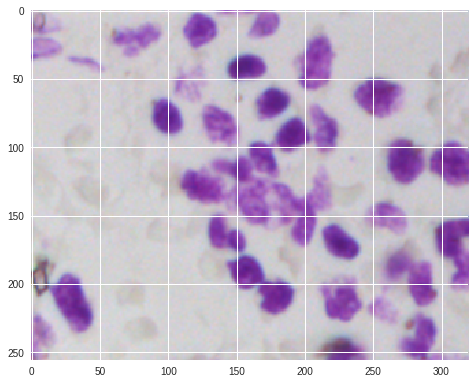

(256, 320, 3)


In [42]:
skimage.io.imshow(img[:,:,:IMG_CHANNELS])
plt.show()
print(img[:,:,:IMG_CHANNELS].shape)

**Observation**: Training images have different dimensions (#pixels!)

In [43]:
#Sanity Check
print(len(imgs_train_original))
#print(imgs_original[0])

670


In [44]:
imgs_train_original[4].shape

(360, 360, 4)

What is the fourth dimension? Let's dive deeper into the data:

In [45]:
imgs_train_original[100][2][0]

array([ 21,  21,  21, 255], dtype=uint8)

**Observation**: The fourth data number associated to each pixel is 255, always! -->No worries

Visualization of the test dataset + Dimensionality of the images:

In [46]:
imgs_test_original = [] #List with all np.arrays that store pixel information
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = skimage.io.imread(path + '/images/' + id_ + '.png')[:,:,:] #Gets a np.array from an image
    imgs_test_original.append(img)
    #skimage.io.imshow(img[:,:,:IMG_CHANNELS])
    #plt.show()
    #print(img[:,:,:IMG_CHANNELS].shape)

100%|██████████| 65/65 [00:00<00:00, 151.75it/s]


In [47]:
#Sanity Check
print(len(imgs_test_original))

65


#### b) Downsampling of images

We will downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. We will use the function resize from skimage (see [doc](http://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html)).

In [48]:
# Get and resize train images and masks(Initialize containers for storing downsampled images)

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8) #dtype recommended for pixels
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool) #dtype recommended for boolean matric

#Note that the output of the NN in image segmentation (two classes) is a boolean matrix 
#with the dimensions of the image

print('Getting and resizing train images and masks ... ')

sys.stdout.flush() #forces it to "flush" the buffer

#Tip: Use tqdm() on top of the iterator to have a progress bar
#enumerate() returns a tuple (index, item) of the iterator. Define 2 looping variables if you use enumerate() 

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = skimage.io.imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    #Image resizing to lower resolution
    img = skimage.transform.resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    #X_train is a tensor of order 4: A "cube" of data <-> n matrices stacked together
    X_train[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool) #Initialize container of the mask
    for mask_file in next(os.walk(path + '/masks/'))[2]:           #Use index 2 for getting name of files (.png)
        mask_ = skimage.io.imread(path + '/masks/' + mask_file)
        #print(mask_.shape) Remove the comment to see how that mask_ is an array of two dimensions! Not three!
        #Insert a new axis
        mask_ = np.expand_dims(skimage.transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1) #preserve_range=True is important!
        #axis = -1 adds an axis at the end of the tuple of dimensions of a np.array
        mask = np.maximum(mask, mask_)
        #mask gets updated at each loop and includes all the masks!
    Y_train[n] = mask #Stores all the masks (true labels in a tensor of order 4: 1 tensor of order 3 per mask)

print('\n Training images succesfully downsampled!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:44<00:00,  4.08it/s]


 Training images succesfully downsampled!


Useful documentation: [np.expand_dims()](https://www.tutorialspoint.com/numpy/numpy_expand_dims.htm), [skimage.transform.resize()](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize)

In [49]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = skimage.io.imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = skimage.transform.resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
print('\n Test images successfully downsampled!')

Getting and resizing test images ... 


100%|██████████| 65/65 [00:01<00:00, 48.85it/s]


 Test images successfully downsampled!


Let's see if things look all right by drawing some random images and their associated masks.

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


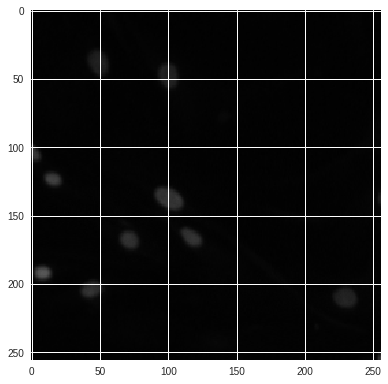

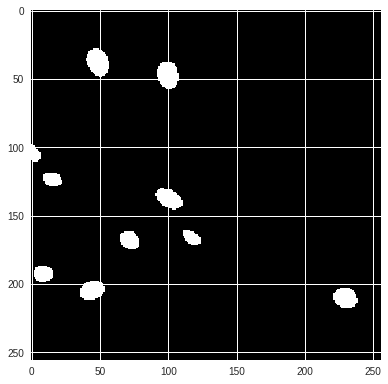

In [50]:
# Check if training data looks all right (downsampled data)
ix = random.randint(0, len(train_ids)) #Generate an indez randomly
skimage.io.imshow(X_train[ix])
plt.show() #Remember: need imshow in conjunction with plt.show() to see images!
skimage.io.imshow(np.squeeze(Y_train[ix]))
plt.show()

### III. Definition of the evaluation metric for the competition

In this section, we try to define the mean average precision at different intersection over union (IoU) thresholds metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so we need to implement this by ourselves. However, in a first stage, we used the [Dice Coefficient](https://stats.stackexchange.com/questions/195006/is-the-dice-coefficient-the-same-as-accuracy/253992). **Needs review**

The Dice score is not only a measure of how many positives you find, but it also penalizes for the false positives that the method finds, similar to precision. So it is more similar to precision than accuracy. The only difference is the denominator, where you have the total number of positives instead of only the positives that the method finds. So the Dice score is also penalizing for the positives that your algorithm/method could not find.

In [51]:
'''smooth = 1e-5

# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
'''

'smooth = 1e-5\n\n# Metric function\ndef dice_coef(y_true, y_pred):\n    y_true_f = K.flatten(y_true)\n    y_pred_f = K.flatten(y_pred)\n    intersection = K.sum(y_true_f * y_pred_f)\n    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)\n\n# Loss funtion\ndef dice_coef_loss(y_true, y_pred):\n    return -dice_coef(y_true, y_pred)\n'

Now, we are going to try to define a IoU metric

In [0]:
#Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

### IV. Definition and training of the Neural Network (U-net)

Some observations on the functions used:

-->```keras.layers.Input()```:

A Keras tensor is a tensor object from the underlying backend (Theano, TensorFlow or CNTK), which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model. (see [doc](https://keras.io/layers/core/))

-->```keras.layers.core.Lambda()```:

Wraps arbitrary expression as a Layer object. (see [doc](https://keras.io/layers/core/))







In [99]:
# Build U-Net model

from keras.layers.merge import concatenate

#### Input Layer

inputs = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) # Input() is used to instantiate a Keras tensor

s = keras.layers.core.Lambda(lambda x: x / 255) (inputs) #Normalize all pixels

##### Block 1: 2 Conv + Dropout + Maxpool

c1 = keras.layers.convolutional.Conv2D(16, (3, 3), 
                                       activation='elu', kernel_initializer='he_normal', padding='same')(s)  #params: num filters, kernel_size

c1 = keras.layers.BatchNormalization()(c1)

c1 = keras.layers.core.Dropout(0.3) (c1)

c1 = keras.layers.convolutional.Conv2D(16, (3, 3), 
                                       activation='elu', kernel_initializer='he_normal', padding='same', 
                                       kernel_regularizer=keras.regularizers.l2(0.45)) (c1)

c1 = keras.layers.BatchNormalization()(c1)

p1 = keras.layers.pooling.MaxPooling2D((2, 2)) (c1)

##### Block 2: 2 Conv + Dropout + Maxpool

c2 = keras.layers.convolutional.Conv2D(32, (3, 3), 
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.45)) (p1)

c2 = keras.layers.BatchNormalization()(c2)

c2 = keras.layers.core.Dropout(0.3) (c2)

c2 = keras.layers.convolutional.Conv2D(32, (3, 3),  
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.45)) (c2)

c2 = keras.layers.BatchNormalization()(c2)

p2 = keras.layers.pooling.MaxPooling2D((2, 2)) (c2)

##### Block 3: 2 Conv + Dropout + Maxpool

c3 = keras.layers.convolutional.Conv2D(64, (3, 3),   
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.45)) (p2)

c3 = keras.layers.BatchNormalization()(c3)

c3 = keras.layers.core.Dropout(0.3) (c3)

c3 = keras.layers.convolutional.Conv2D(64, (3, 3),   
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.45)) (c3)

c3 = keras.layers.BatchNormalization()(c3)

p3 = keras.layers.pooling.MaxPooling2D((2, 2)) (c3)

##### Block 4: 2 Conv + Dropout + Maxpool

c4 = keras.layers.convolutional.Conv2D(128, (3, 3),  
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.45)) (p3)

c4 = keras.layers.BatchNormalization()(c4)

c4 = keras.layers.core.Dropout(0.4) (c4)

c4 = keras.layers.convolutional.Conv2D(128, (3, 3),  
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.45)) (c4)

c4 = keras.layers.BatchNormalization()(c4)

p4 = keras.layers.pooling.MaxPooling2D(pool_size=(2, 2)) (c4)

##### Block 5: 2 Conv + Dropout + Maxpool

c5 = keras.layers.convolutional.Conv2D(256, (3, 3),  
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.45)) (p4)

c5 = keras.layers.BatchNormalization()(c5)

c5 = keras.layers.core.Dropout(0.4) (c5)

c5 = keras.layers.convolutional.Conv2D(256, (3, 3),  
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.45)) (c5)

c5 = keras.layers.BatchNormalization()(c5)

#### Block 6: Deconvolution + Concatenate + Convolution + Dropout + Convolution

u6 = keras.layers.convolutional.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', 
                                                kernel_regularizer=keras.regularizers.l2(0.)) (c5)

u6 = concatenate([u6, c4])

c6 = keras.layers.convolutional.Conv2D(128, (3, 3),  
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.)) (u6)

c6 = keras.layers.core.Dropout(0.4) (c6)

c6 = keras.layers.convolutional.Conv2D(128, (3, 3),  
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.)) (c6)

#### Block 7: Deconvolution + Concatenate + Convolution + Dropout + Convolution

u7 = keras.layers.convolutional.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', 
                                               kernel_regularizer=keras.regularizers.l2(0.)) (c6)  
u7 = concatenate([u7, c3])

c7 = keras.layers.convolutional.Conv2D(64, (3, 3),   
                                       activation='elu', kernel_initializer='he_normal', padding='same', 
                                       kernel_regularizer=keras.regularizers.l2(0.)) (u7)
c7 = keras.layers.core.Dropout(0.4) (c7)
c7 = keras.layers.convolutional.Conv2D(64, (3, 3),   
                                       activation='elu', kernel_initializer='he_normal', padding='same', 
                                       kernel_regularizer=keras.regularizers.l2(0.)) (c7)

#### Block 8: Deconvolution + Concatenate + Convolution + Dropout + Convolution

u8 = keras.layers.convolutional.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', 
                                                kernel_regularizer=keras.regularizers.l2(0.)) (c7)

u8 = concatenate([u8, c2])

c8 = keras.layers.convolutional.Conv2D(32, (3, 3),   
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.)) (u8)

c8 = keras.layers.core.Dropout(0.3) (c8)

c8 = keras.layers.convolutional.Conv2D(32, (3, 3),   
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.)) (c8)

#### Block 9: Deconvolution + Concatenate + Convolution + Dropout + Convolution

u9 = keras.layers.convolutional.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', 
                                               kernel_regularizer=keras.regularizers.l2(0.)) (c8)

u9 = concatenate([u9, c1], axis=3)

c9 = keras.layers.convolutional.Conv2D(16, (3, 3),   
                                       activation='elu', kernel_initializer='he_normal', padding='same', 
                                       kernel_regularizer=keras.regularizers.l2(0.)) (u9)

c9 = keras.layers.core.Dropout(0.3) (c9)

c9 = keras.layers.convolutional.Conv2D(16, (3, 3),   
                                       activation='elu', kernel_initializer='he_normal', padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.)) (c9)

#### Output Layer: Logistic Unit

outputs = keras.layers.convolutional.Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 256, 256, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 16) 448         lambda_5[0][0]                   
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 256, 256, 16) 64          conv2d_77[0][0]                  
__________________________________________________________________________________________________
dropout_37

#### a) Training set up

A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

Some observations on the functions used:

-->```keras.callbacks.EarlyStopping()```: Stop training when a monitored quantity has stopped improving. Parameters:

- patience: number of epochs with no improvement after which training will be stopped

- verbose: verbosity mode

--> ```keras.callbacks.ModelCheckpoint()```: Save the model after every epoch. Parameters:

- filepath: string, path to save the model file
- save_best_only: if save_best_only = True, the latest best model according to the quantity monitored will not be overwritten.

--> ```model.fit()```: Parameters:

- validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling.

- batch_size: Integer or None. Number of samples per gradient update. If unspecified, it will default to 32.

In [100]:
### Fit model

# Keras models are trained on Numpy arrays of input data and labels. For training a model, you will typically use the  fit function.

earlystopper = keras.callbacks.EarlyStopping(patience=100, verbose=1) 
checkpointer = keras.callbacks.ModelCheckpoint('Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/100
603/603 [==============================] - 32s 53ms/step - loss: 343.8400 - mean_iou: 0.1018 - val_loss: 130.1584 - val_mean_iou: 0.1530

Epoch 00001: val_loss improved from inf to 130.15839, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 2/100
603/603 [==============================] - 26s 43ms/step - loss: 69.9969 - mean_iou: 0.1917 - val_loss: 32.9705 - val_mean_iou: 0.2272

Epoch 00002: val_loss improved from 130.15839 to 32.97047, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 3/100
603/603 [==============================] - 26s 43ms/step - loss: 20.0688 - mean_iou: 0.2410 - val_loss: 11.1895 - val_mean_iou: 0.2531

Epoch 00003: val_loss improved from 32.97047 to 11.18953, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 4/100
603/603 [==============================] - 26s 43ms/step - loss: 7.2828 - mean_iou: 0.2654 - val_loss: 4.6445 - val_mean_iou: 0.

603/603 [==============================] - 26s 43ms/step - loss: 3.3686 - mean_iou: 0.2762 - val_loss: 2.4784 - val_mean_iou: 0.2767

Epoch 00005: val_loss improved from 4.64448 to 2.47845, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 6/100
603/603 [==============================] - 26s 43ms/step - loss: 1.5443 - mean_iou: 0.2794 - val_loss: 1.2373 - val_mean_iou: 0.2818

Epoch 00006: val_loss improved from 2.47845 to 1.23731, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 7/100
603/603 [==============================] - 26s 43ms/step - loss: 0.8095 - mean_iou: 0.2844 - val_loss: 0.7679 - val_mean_iou: 0.2864

Epoch 00007: val_loss improved from 1.23731 to 0.76794, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 8/100
603/603 [==============================] - 26s 43ms/step - loss: 0.5298 - mean_iou: 0.2864 - val_loss: 0.7410 - val_mean_iou: 0.2884

Epoch 00008: val_loss improved from 0.76794 to 0.74103, saving

603/603 [==============================] - 26s 43ms/step - loss: 0.2887 - mean_iou: 0.2899 - val_loss: 0.6374 - val_mean_iou: 0.2927

Epoch 00009: val_loss improved from 0.74103 to 0.63742, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 10/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2531 - mean_iou: 0.2947 - val_loss: 0.5388 - val_mean_iou: 0.2964

Epoch 00010: val_loss improved from 0.63742 to 0.53882, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 11/100
603/603 [==============================] - 26s 43ms/step - loss: 0.3040 - mean_iou: 0.2969 - val_loss: 0.5612 - val_mean_iou: 0.2986

Epoch 00011: val_loss did not improve
Epoch 12/100
603/603 [==============================] - 26s 43ms/step - loss: 0.3109 - mean_iou: 0.2988 - val_loss: 0.3607 - val_mean_iou: 0.3004

Epoch 00012: val_loss improved from 0.53882 to 0.36070, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 13/100
384/603 

603/603 [==============================] - 26s 43ms/step - loss: 0.2366 - mean_iou: 0.3024 - val_loss: 0.3550 - val_mean_iou: 0.3042

Epoch 00013: val_loss improved from 0.36070 to 0.35497, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 14/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1872 - mean_iou: 0.3054 - val_loss: 0.3507 - val_mean_iou: 0.3068

Epoch 00014: val_loss improved from 0.35497 to 0.35067, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 15/100
603/603 [==============================] - 26s 43ms/step - loss: 0.3683 - mean_iou: 0.3071 - val_loss: 0.3128 - val_mean_iou: 0.3082

Epoch 00015: val_loss improved from 0.35067 to 0.31279, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 16/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2834 - mean_iou: 0.3103 - val_loss: 0.8333 - val_mean_iou: 0.3113

Epoch 00016: val_loss did not improve
Epoch 17/100
336/603 

603/603 [==============================] - 26s 43ms/step - loss: 0.4602 - mean_iou: 0.3111 - val_loss: 0.2667 - val_mean_iou: 0.3120

Epoch 00017: val_loss improved from 0.31279 to 0.26674, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 18/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2135 - mean_iou: 0.3128 - val_loss: 0.1973 - val_mean_iou: 0.3140

Epoch 00018: val_loss improved from 0.26674 to 0.19725, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 19/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1825 - mean_iou: 0.3154 - val_loss: 0.4657 - val_mean_iou: 0.3165

Epoch 00019: val_loss did not improve
Epoch 20/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1930 - mean_iou: 0.3173 - val_loss: 0.1922 - val_mean_iou: 0.3186

Epoch 00020: val_loss improved from 0.19725 to 0.19218, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 21/100
384/603 

603/603 [==============================] - 26s 43ms/step - loss: 0.1852 - mean_iou: 0.3193 - val_loss: 0.2002 - val_mean_iou: 0.3205

Epoch 00021: val_loss did not improve
Epoch 22/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2020 - mean_iou: 0.3215 - val_loss: 0.2317 - val_mean_iou: 0.3226

Epoch 00022: val_loss did not improve
Epoch 23/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2452 - mean_iou: 0.3235 - val_loss: 0.2702 - val_mean_iou: 0.3245

Epoch 00023: val_loss did not improve
Epoch 24/100
603/603 [==============================] - 26s 43ms/step - loss: 0.4049 - mean_iou: 0.3249 - val_loss: 0.2759 - val_mean_iou: 0.3255

Epoch 00024: val_loss did not improve
Epoch 25/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2364 - mean_iou: 0.3263 - val_loss: 0.2086 - val_mean_iou: 0.3272

Epoch 00025: val_loss did not improve
Epoch 26/100
192/603 [========>.....................] - ETA: 16s - loss: 0.1923 - mean_i

603/603 [==============================] - 26s 43ms/step - loss: 0.1780 - mean_iou: 0.3278 - val_loss: 0.2468 - val_mean_iou: 0.3285

Epoch 00026: val_loss did not improve
Epoch 27/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2520 - mean_iou: 0.3293 - val_loss: 1.1554 - val_mean_iou: 0.3297

Epoch 00027: val_loss did not improve
Epoch 28/100
603/603 [==============================] - 26s 43ms/step - loss: 0.4760 - mean_iou: 0.3295 - val_loss: 0.2615 - val_mean_iou: 0.3298

Epoch 00028: val_loss did not improve
Epoch 29/100
603/603 [==============================] - 26s 43ms/step - loss: 0.3805 - mean_iou: 0.3303 - val_loss: 0.5583 - val_mean_iou: 0.3308

Epoch 00029: val_loss did not improve
Epoch 30/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1963 - mean_iou: 0.3312 - val_loss: 0.6396 - val_mean_iou: 0.3317

Epoch 00030: val_loss did not improve
Epoch 31/100
176/603 [=======>......................] - ETA: 17s - loss: 0.1411 - mean_i

603/603 [==============================] - 26s 43ms/step - loss: 0.1501 - mean_iou: 0.3319 - val_loss: 0.4971 - val_mean_iou: 0.3323

Epoch 00031: val_loss did not improve
Epoch 32/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2293 - mean_iou: 0.3324 - val_loss: 0.4856 - val_mean_iou: 0.3327

Epoch 00032: val_loss did not improve
Epoch 33/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1483 - mean_iou: 0.3331 - val_loss: 0.4016 - val_mean_iou: 0.3336

Epoch 00033: val_loss did not improve
Epoch 34/100
603/603 [==============================] - 26s 43ms/step - loss: 0.4508 - mean_iou: 0.3335 - val_loss: 0.3079 - val_mean_iou: 0.3340

Epoch 00034: val_loss did not improve
Epoch 35/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1671 - mean_iou: 0.3345 - val_loss: 0.5720 - val_mean_iou: 0.3349

Epoch 00035: val_loss did not improve
Epoch 36/100
176/603 [=======>......................] - ETA: 17s - loss: 0.1243 - mean_i

603/603 [==============================] - 26s 43ms/step - loss: 0.1540 - mean_iou: 0.3350 - val_loss: 0.5102 - val_mean_iou: 0.3354

Epoch 00036: val_loss did not improve
Epoch 37/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2824 - mean_iou: 0.3356 - val_loss: 0.2391 - val_mean_iou: 0.3360

Epoch 00037: val_loss did not improve
Epoch 38/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1413 - mean_iou: 0.3364 - val_loss: 0.4344 - val_mean_iou: 0.3367

Epoch 00038: val_loss did not improve
Epoch 39/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1307 - mean_iou: 0.3370 - val_loss: 0.5624 - val_mean_iou: 0.3373

Epoch 00039: val_loss did not improve
Epoch 40/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2545 - mean_iou: 0.3373 - val_loss: 0.2115 - val_mean_iou: 0.3377

Epoch 00040: val_loss did not improve
Epoch 41/100
176/603 [=======>......................] - ETA: 17s - loss: 0.2179 - mean_i

603/603 [==============================] - 26s 43ms/step - loss: 0.2011 - mean_iou: 0.3382 - val_loss: 0.3033 - val_mean_iou: 0.3387

Epoch 00041: val_loss did not improve
Epoch 42/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1777 - mean_iou: 0.3391 - val_loss: 0.1608 - val_mean_iou: 0.3395

Epoch 00042: val_loss improved from 0.19218 to 0.16084, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 43/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1280 - mean_iou: 0.3399 - val_loss: 0.2515 - val_mean_iou: 0.3403

Epoch 00043: val_loss did not improve
Epoch 44/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1369 - mean_iou: 0.3406 - val_loss: 0.1773 - val_mean_iou: 0.3411

Epoch 00044: val_loss did not improve
Epoch 45/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1557 - mean_iou: 0.3415 - val_loss: 0.2074 - val_mean_iou: 0.3418

Epoch 00045: val_loss did not improve
Epoc

603/603 [==============================] - 26s 43ms/step - loss: 0.1512 - mean_iou: 0.3420 - val_loss: 0.2390 - val_mean_iou: 0.3425

Epoch 00046: val_loss did not improve
Epoch 47/100
603/603 [==============================] - 26s 43ms/step - loss: 0.4212 - mean_iou: 0.3428 - val_loss: 0.7651 - val_mean_iou: 0.3432

Epoch 00047: val_loss did not improve
Epoch 48/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2451 - mean_iou: 0.3435 - val_loss: 0.1834 - val_mean_iou: 0.3439

Epoch 00048: val_loss did not improve
Epoch 49/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1365 - mean_iou: 0.3442 - val_loss: 0.1690 - val_mean_iou: 0.3447

Epoch 00049: val_loss did not improve
Epoch 50/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1472 - mean_iou: 0.3449 - val_loss: 0.3641 - val_mean_iou: 0.3452

Epoch 00050: val_loss did not improve
Epoch 51/100
160/603 [======>.......................] - ETA: 18s - loss: 0.2502 - mean_i

603/603 [==============================] - 26s 43ms/step - loss: 0.1626 - mean_iou: 0.3456 - val_loss: 0.1990 - val_mean_iou: 0.3459

Epoch 00051: val_loss did not improve
Epoch 52/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1257 - mean_iou: 0.3461 - val_loss: 0.1502 - val_mean_iou: 0.3464

Epoch 00052: val_loss improved from 0.16084 to 0.15020, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 53/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1532 - mean_iou: 0.3468 - val_loss: 0.1935 - val_mean_iou: 0.3472

Epoch 00053: val_loss did not improve
Epoch 54/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1870 - mean_iou: 0.3475 - val_loss: 0.1885 - val_mean_iou: 0.3478

Epoch 00054: val_loss did not improve
Epoch 55/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1683 - mean_iou: 0.3481 - val_loss: 0.5534 - val_mean_iou: 0.3485

Epoch 00055: val_loss did not improve
Epoc

603/603 [==============================] - 26s 43ms/step - loss: 0.3492 - mean_iou: 0.3487 - val_loss: 0.2677 - val_mean_iou: 0.3489

Epoch 00056: val_loss did not improve
Epoch 57/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1596 - mean_iou: 0.3492 - val_loss: 0.1832 - val_mean_iou: 0.3495

Epoch 00057: val_loss did not improve
Epoch 58/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1358 - mean_iou: 0.3498 - val_loss: 0.1902 - val_mean_iou: 0.3501

Epoch 00058: val_loss did not improve
Epoch 59/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1865 - mean_iou: 0.3502 - val_loss: 0.2434 - val_mean_iou: 0.3504

Epoch 00059: val_loss did not improve
Epoch 60/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1296 - mean_iou: 0.3507 - val_loss: 0.1729 - val_mean_iou: 0.3510

Epoch 00060: val_loss did not improve
Epoch 61/100
160/603 [======>.......................] - ETA: 18s - loss: 0.1528 - mean_i

603/603 [==============================] - 26s 43ms/step - loss: 0.9075 - mean_iou: 0.3512 - val_loss: 1.5151 - val_mean_iou: 0.3514

Epoch 00061: val_loss did not improve
Epoch 62/100
603/603 [==============================] - 26s 43ms/step - loss: 0.4527 - mean_iou: 0.3517 - val_loss: 0.2087 - val_mean_iou: 0.3519

Epoch 00062: val_loss did not improve
Epoch 63/100
603/603 [==============================] - 26s 43ms/step - loss: 0.4525 - mean_iou: 0.3520 - val_loss: 0.3394 - val_mean_iou: 0.3522

Epoch 00063: val_loss did not improve
Epoch 64/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2281 - mean_iou: 0.3525 - val_loss: 0.2628 - val_mean_iou: 0.3527

Epoch 00064: val_loss did not improve
Epoch 65/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1466 - mean_iou: 0.3529 - val_loss: 0.1713 - val_mean_iou: 0.3531

Epoch 00065: val_loss did not improve
Epoch 66/100
176/603 [=======>......................] - ETA: 17s - loss: 0.1346 - mean_i

603/603 [==============================] - 26s 43ms/step - loss: 0.1463 - mean_iou: 0.3532 - val_loss: 0.1543 - val_mean_iou: 0.3535

Epoch 00066: val_loss did not improve
Epoch 67/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1120 - mean_iou: 0.3537 - val_loss: 0.2246 - val_mean_iou: 0.3539

Epoch 00067: val_loss did not improve
Epoch 68/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1253 - mean_iou: 0.3541 - val_loss: 0.2142 - val_mean_iou: 0.3543

Epoch 00068: val_loss did not improve
Epoch 69/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1356 - mean_iou: 0.3545 - val_loss: 0.1329 - val_mean_iou: 0.3548

Epoch 00069: val_loss improved from 0.15020 to 0.13286, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 70/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1502 - mean_iou: 0.3549 - val_loss: 0.2191 - val_mean_iou: 0.3552

Epoch 00070: val_loss did not improve
Epoc

603/603 [==============================] - 26s 43ms/step - loss: 0.1345 - mean_iou: 0.3554 - val_loss: 0.1727 - val_mean_iou: 0.3555

Epoch 00071: val_loss did not improve
Epoch 72/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1217 - mean_iou: 0.3558 - val_loss: 0.1433 - val_mean_iou: 0.3560

Epoch 00072: val_loss did not improve
Epoch 73/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1306 - mean_iou: 0.3562 - val_loss: 0.1996 - val_mean_iou: 0.3564

Epoch 00073: val_loss did not improve
Epoch 74/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1575 - mean_iou: 0.3564 - val_loss: 0.1325 - val_mean_iou: 0.3566

Epoch 00074: val_loss improved from 0.13286 to 0.13250, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 75/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2988 - mean_iou: 0.3568 - val_loss: 0.1371 - val_mean_iou: 0.3570

Epoch 00075: val_loss did not improve
Epoc

603/603 [==============================] - 26s 43ms/step - loss: 0.1328 - mean_iou: 0.3572 - val_loss: 0.1750 - val_mean_iou: 0.3573

Epoch 00076: val_loss did not improve
Epoch 77/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1412 - mean_iou: 0.3575 - val_loss: 0.2722 - val_mean_iou: 0.3576

Epoch 00077: val_loss did not improve
Epoch 78/100
603/603 [==============================] - 26s 43ms/step - loss: 0.0974 - mean_iou: 0.3578 - val_loss: 0.2988 - val_mean_iou: 0.3580

Epoch 00078: val_loss did not improve
Epoch 79/100
603/603 [==============================] - 26s 43ms/step - loss: 0.2386 - mean_iou: 0.3580 - val_loss: 0.2795 - val_mean_iou: 0.3580

Epoch 00079: val_loss did not improve
Epoch 80/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1649 - mean_iou: 0.3582 - val_loss: 0.2342 - val_mean_iou: 0.3583

Epoch 00080: val_loss did not improve
Epoch 81/100
160/603 [======>.......................] - ETA: 18s - loss: 0.1927 - mean_i

603/603 [==============================] - 26s 43ms/step - loss: 0.1465 - mean_iou: 0.3585 - val_loss: 0.1668 - val_mean_iou: 0.3587

Epoch 00081: val_loss did not improve
Epoch 82/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1121 - mean_iou: 0.3589 - val_loss: 0.4849 - val_mean_iou: 0.3589

Epoch 00082: val_loss did not improve
Epoch 83/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1690 - mean_iou: 0.3589 - val_loss: 0.1373 - val_mean_iou: 0.3591

Epoch 00083: val_loss did not improve
Epoch 84/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1147 - mean_iou: 0.3593 - val_loss: 0.1580 - val_mean_iou: 0.3594

Epoch 00084: val_loss did not improve
Epoch 85/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1219 - mean_iou: 0.3595 - val_loss: 0.1394 - val_mean_iou: 0.3597

Epoch 00085: val_loss did not improve
Epoch 86/100
176/603 [=======>......................] - ETA: 17s - loss: 0.1117 - mean_i

603/603 [==============================] - 26s 43ms/step - loss: 0.1060 - mean_iou: 0.3599 - val_loss: 0.1186 - val_mean_iou: 0.3601

Epoch 00086: val_loss improved from 0.13250 to 0.11856, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 87/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1038 - mean_iou: 0.3603 - val_loss: 0.1322 - val_mean_iou: 0.3604

Epoch 00087: val_loss did not improve
Epoch 88/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1171 - mean_iou: 0.3606 - val_loss: 0.1123 - val_mean_iou: 0.3608

Epoch 00088: val_loss improved from 0.11856 to 0.11233, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 89/100
603/603 [==============================] - 26s 43ms/step - loss: 0.4968 - mean_iou: 0.3609 - val_loss: 0.2442 - val_mean_iou: 0.3611

Epoch 00089: val_loss did not improve
Epoch 90/100
464/603 [======================>.......] - ETA: 5s - loss: 0.2677 - mean_iou: 0.3612

603/603 [==============================] - 26s 43ms/step - loss: 0.2843 - mean_iou: 0.3613 - val_loss: 0.2689 - val_mean_iou: 0.3614

Epoch 00090: val_loss did not improve
Epoch 91/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1640 - mean_iou: 0.3614 - val_loss: 0.2007 - val_mean_iou: 0.3615

Epoch 00091: val_loss did not improve
Epoch 92/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1140 - mean_iou: 0.3616 - val_loss: 0.1153 - val_mean_iou: 0.3618

Epoch 00092: val_loss did not improve
Epoch 93/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1274 - mean_iou: 0.3619 - val_loss: 0.1817 - val_mean_iou: 0.3620

Epoch 00093: val_loss did not improve
Epoch 94/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1084 - mean_iou: 0.3621 - val_loss: 0.1219 - val_mean_iou: 0.3623

Epoch 00094: val_loss did not improve
Epoch 95/100
192/603 [========>.....................] - ETA: 16s - loss: 0.1307 - mean_i

603/603 [==============================] - 26s 43ms/step - loss: 0.1179 - mean_iou: 0.3624 - val_loss: 0.1120 - val_mean_iou: 0.3626

Epoch 00095: val_loss improved from 0.11233 to 0.11199, saving model to Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5
Epoch 96/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1150 - mean_iou: 0.3628 - val_loss: 0.1388 - val_mean_iou: 0.3629

Epoch 00096: val_loss did not improve
Epoch 97/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1885 - mean_iou: 0.3629 - val_loss: 0.1753 - val_mean_iou: 0.3630

Epoch 00097: val_loss did not improve
Epoch 98/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1156 - mean_iou: 0.3631 - val_loss: 0.1198 - val_mean_iou: 0.3632

Epoch 00098: val_loss did not improve
Epoch 99/100
592/603 [============================>.] - ETA: 0s - loss: 0.1504 - mean_iou: 0.3633

603/603 [==============================] - 26s 43ms/step - loss: 0.1512 - mean_iou: 0.3633 - val_loss: 0.2045 - val_mean_iou: 0.3635

Epoch 00099: val_loss did not improve
Epoch 100/100
603/603 [==============================] - 26s 43ms/step - loss: 0.1330 - mean_iou: 0.3636 - val_loss: 0.1708 - val_mean_iou: 0.3638

Epoch 00100: val_loss did not improve


dict_keys(['val_loss', 'val_mean_iou', 'loss', 'mean_iou'])


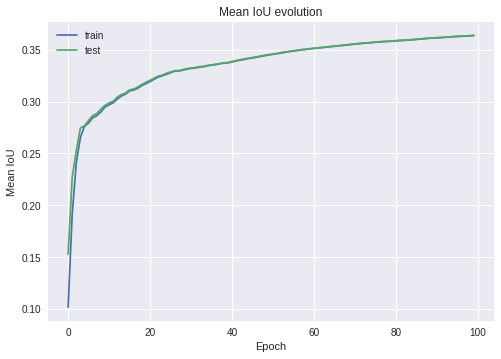

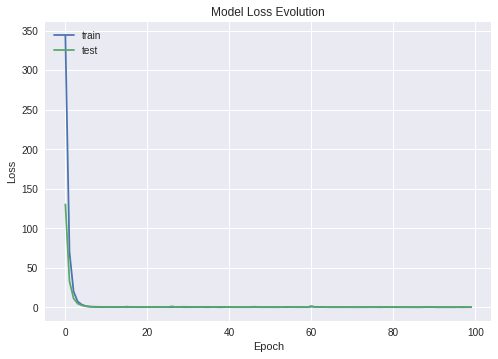

In [101]:
import matplotlib.pyplot as plt

history = results #Output model.fit()

# list all data in history
print(history.history.keys())

# summarize history for accuracy
fig_accuracy = plt.figure(1)
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('Mean IoU evolution')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_accuracy.savefig('Accuracy_Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.png')

# summarize history for loss
fig_loss = plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_loss.savefig('Loss_Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.png')

In [102]:
!ls -l

total 161408
-rw-r--r--   1 root root    16579 Mar  4 22:59 Accuracy_Unet-MeanIoU-100e-Res256-BN-dropA0.2.png
-rw-r--r--   1 root root    16579 Mar  5 00:21 Accuracy_Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45.png
-rw-r--r--   1 root root    17220 Mar  5 02:29 Accuracy_Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.png
-rw-r--r--   1 root root    21923 Mar  4 21:42 Accuracy_Unet-MeanIoU-80e-Res256-BN-dropA0.2.png
drwxr-xr-x   1 root root     4096 Mar  4 18:15 datalab
-rw-r--r--   1 root root    29723 Mar  4 22:59 Loss_Unet-MeanIoU-100e-Res256-BN-dropA0.2.png
-rw-r--r--   1 root root    29723 Mar  5 00:21 Loss_Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45.png
-rw-r--r--   1 root root    15021 Mar  5 02:29 Loss_Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.png
-rw-r--r--   1 root root    34338 Mar  4 21:42 Loss_Unet-MeanIoU-80e-Res256-BN-dropA0.2.png
drwxr-xr-x  67 root root    12288 Mar  4 18:21 stage1_test
-rw-r--r--   1 root root  9545388 Mar  4 18:21 stage1_test.zip
drwxr-xr-x 672 r

In [61]:
!tail model-dsbowl2018-1.h5

tail: cannot open 'model-dsbowl2018-1.h5' for reading: No such file or directory


#### V. Make predictions 

In [103]:
# Load trained U-net with best weights
model = keras.models.load_model('Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5', custom_objects={'mean_iou': mean_iou}) 
#custom_objects: Optional dictionary mapping names (strings) to custom classes or functions to be considered during deserialization.

# Predict
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1) #Train set: You know, Keras uses the last 0.1 as dev set!
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1) #Dev set
preds_test = model.predict(X_test, verbose=1) #Test set

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

print(preds_test.shape)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(skimage.transform.resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))



65/65 [==============================] - 1s 10ms/step
(65, 256, 256, 1)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


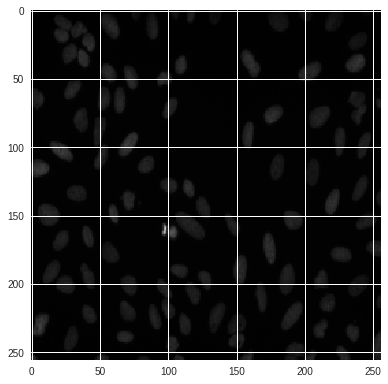

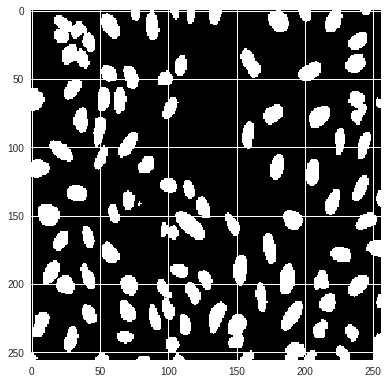

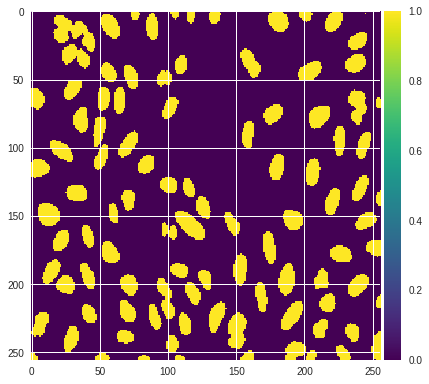

In [104]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))

skimage.io.imshow(X_train[ix])
plt.show()
skimage.io.imshow(np.squeeze(Y_train[ix]))
plt.show()
skimage.io.imshow(np.squeeze(preds_train_t[ix]))
plt.show()

51


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


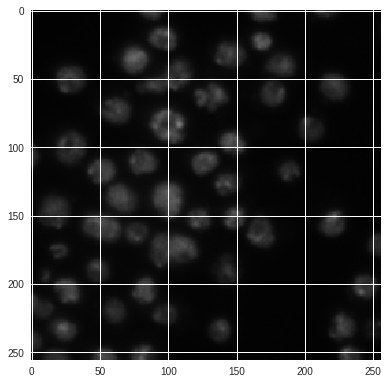

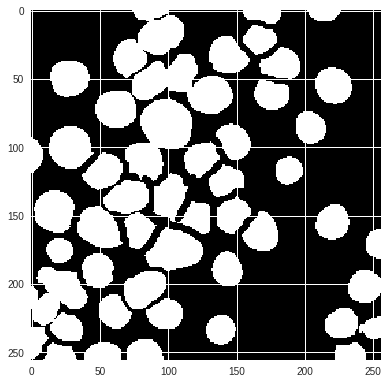

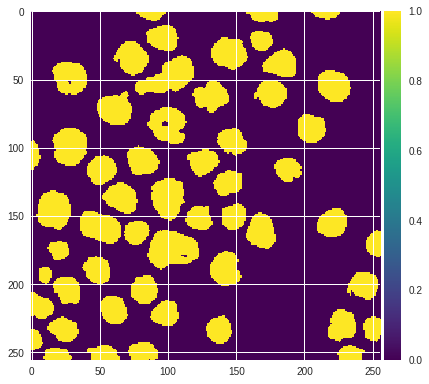

In [105]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
print(ix)

skimage.io.imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
skimage.io.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
skimage.io.imshow(np.squeeze(preds_val_t[ix]))
plt.show()

### V. Encode and submit results

In [0]:
# Run-length encoding from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = skimage.morphology.label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [0]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.csv', index=False)

In [110]:
!ls -l

total 162480
-rw-r--r--   1 root root    16579 Mar  4 22:59 Accuracy_Unet-MeanIoU-100e-Res256-BN-dropA0.2.png
-rw-r--r--   1 root root    16579 Mar  5 00:21 Accuracy_Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45.png
-rw-r--r--   1 root root    17220 Mar  5 02:29 Accuracy_Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.png
-rw-r--r--   1 root root    21923 Mar  4 21:42 Accuracy_Unet-MeanIoU-80e-Res256-BN-dropA0.2.png
drwxr-xr-x   1 root root     4096 Mar  4 18:15 datalab
-rw-r--r--   1 root root    29723 Mar  4 22:59 Loss_Unet-MeanIoU-100e-Res256-BN-dropA0.2.png
-rw-r--r--   1 root root    29723 Mar  5 00:21 Loss_Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45.png
-rw-r--r--   1 root root    15021 Mar  5 02:29 Loss_Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.png
-rw-r--r--   1 root root    34338 Mar  4 21:42 Loss_Unet-MeanIoU-80e-Res256-BN-dropA0.2.png
drwxr-xr-x  67 root root    12288 Mar  4 18:21 stage1_test
-rw-r--r--   1 root root  9545388 Mar  4 18:21 stage1_test.zip
drwxr-xr-x 672 r

In [0]:
# Code to download files from Google colab, locally

from google.colab import files

files.download('Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.csv')
files.download('Accuracy_Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.png')
files.download('Loss_Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.png')
files.download('Unet-MeanIoU-100e-Res256-BN-dropA0.2-Reg0.45v2.h5')


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'model-dsbowl2018-MeanIoU-50e-v2.csv'})
uploaded.GetContentFile('model-dsbowl2018-MeanIoU-50e-v2.csv')  
print('Uploaded file with ID {}'.format(uploaded.get('id')))

FileNotUploadedError: ignored